In [60]:
import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import forestci as fci


In [2]:
signal = pd.read_csv("resonances0.txt", delim_whitespace=True)

In [3]:
signal.shape, signal.head()

((300, 12),
     Z  El   A   Io      Bn     D0    dD    S0    dS    Gg   dG  Com.
 0  11  Na  23  1.5   6.960  100.0  20.0  0.25  0.15     -    -  *07I
 1  12  Mg  24  0.0   7.331  480.0  70.0  0.00  0.00     -    -  *07I
 2  12  Mg  25  2.5  11.094   50.0  10.0  0.00  0.00     -    -  *07I
 3  12  Mg  26  0.0   6.446  210.0  80.0  0.00  0.00     -    -  *07I
 4  13  Al  27  2.5   7.725   55.0   6.0  2.30  0.50  1600  400   07I)

In [4]:
pd.concat([signal.describe(include='all'), signal.dtypes.to_frame().T])


,Z,El,A,Io,Bn,D0,dD,S0,dS,Gg,dG,Com.
count,300.0,300,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300,300,300
unique,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129,48,26
top,NaN,Sn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-,96I
freq,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,52,70
mean,55.503333,NaN,134.586667,1.14,7.054117,9.802936,1.774252,1.4328,0.2777,NaN,NaN,NaN
std,22.893018,NaN,61.025154,1.581794,1.440705,42.435471,8.097214,1.229216,0.247061,NaN,NaN,NaN
min,11.0,NaN,23.0,0.0,3.937,0.00027,0.00002,0.0,0.0,NaN,NaN,NaN
25%,37.75,NaN,86.0,0.0,6.09975,0.014,0.0015,0.515,0.1,NaN,NaN,NaN
50%,56.0,NaN,134.0,0.0,6.7835,0.1025,0.019,1.2,0.2,NaN,NaN,NaN
75%,72.0,NaN,178.25,2.5,7.83325,1.5,0.235,2.0,0.4,NaN,NaN,NaN


In [5]:
x = signal[['Z','A']]
y = signal[['D0']]
arr_x = x.values.reshape(-1,2)
arr_y = y.values.ravel()
print(arr_x,arr_y)

[[ 11  23]
 [ 12  24]
 [ 12  25]
 [ 12  26]
 [ 13  27]
 [ 14  28]
 [ 14  29]
 [ 14  30]
 [ 15  31]
 [ 16  32]
 [ 16  33]
 [ 16  34]
 [ 17  35]
 [ 17  37]
 [ 18  40]
 [ 19  39]
 [ 19  41]
 [ 20  40]
 [ 20  42]
 [ 20  43]
 [ 20  44]
 [ 21  45]
 [ 22  46]
 [ 22  47]
 [ 22  48]
 [ 22  49]
 [ 22  50]
 [ 23  50]
 [ 23  51]
 [ 24  50]
 [ 24  52]
 [ 24  53]
 [ 24  54]
 [ 25  55]
 [ 26  54]
 [ 26  56]
 [ 26  57]
 [ 26  58]
 [ 27  59]
 [ 28  58]
 [ 28  59]
 [ 28  60]
 [ 28  61]
 [ 28  62]
 [ 28  64]
 [ 29  63]
 [ 29  65]
 [ 30  64]
 [ 30  66]
 [ 30  67]
 [ 30  68]
 [ 30  70]
 [ 31  69]
 [ 31  71]
 [ 32  70]
 [ 32  72]
 [ 32  73]
 [ 32  74]
 [ 32  76]
 [ 33  75]
 [ 34  74]
 [ 34  76]
 [ 34  77]
 [ 34  78]
 [ 34  80]
 [ 34  82]
 [ 35  79]
 [ 35  81]
 [ 36  78]
 [ 36  80]
 [ 36  83]
 [ 36  84]
 [ 36  86]
 [ 37  85]
 [ 37  87]
 [ 38  84]
 [ 38  86]
 [ 38  87]
 [ 38  88]
 [ 39  89]
 [ 40  90]
 [ 40  91]
 [ 40  92]
 [ 40  93]
 [ 40  94]
 [ 40  96]
 [ 41  93]
 [ 42  92]
 [ 42  94]
 [ 42  95]
 [ 42  96]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(arr_x, arr_y, test_size=0.2, random_state=11)

# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

In [57]:
rf = RandomForestRegressor(n_estimators=100,max_depth=11,random_state=10,max_features=2)
rf.fit(X_train,y_train)
rf.score(X_train,y_train)

0.9001794312562792

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': np.arange(100,1000,100)},
              {'max_depth': np.arange(1,11,1)}]

grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                       param_grid=param_grid,
                       refit=True,
                       cv=3,
                       scoring ='accuracy',
                       n_jobs=-1)

%time grid_search.fit(X_train, y_train) 
best_score = grid_search.best_score_
best_params = grid_search.best_params_
#results=grid_search.cv_results_
sorted(grid_search.cv_results_.keys())
best_params, best_score

C:\Users\Jeroen\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(


Wall time: 10.2 s


({'n_estimators': 100}, nan)

In [49]:
test_data = pd.read_csv("test.txt", delim_whitespace=True)
test_data = test_data[['Z','A']]
test_data = test_data.values.reshape(-1,2)
print(test_data)

[[22 45]
 [23 50]
 [25 52]
 [27 56]
 [29 58]
 [29 60]
 [29 61]
 [29 62]
 [29 64]
 [30 63]
 [30 65]
 [31 64]
 [31 66]
 [31 68]
 [33 70]
 [33 72]
 [33 74]
 [39 84]
 [39 88]
 [40 89]]


In [33]:
rf.predict(test_data)

array([12.6945    ,  6.80841667, 17.937     , 15.38951667,  7.52588524,
        2.32980857,  3.4366419 ,  5.76347524,  2.19280424,  3.67894524,
        2.48776257,  1.74019133,  2.25297723,  2.55629866,  1.7604156 ,
        1.04222727,  1.23261327,  2.01546571, 14.11305638,  6.16767829])

In [34]:
rf.predict([[28,60]])

array([2.96140667])

In [83]:
y_pred = rf.predict(X_test)
print(y_pred)

[4.24643046e-02 8.97244652e-02 1.30123779e+00 2.52492202e-02
 4.27100000e+01 2.14782177e-01 2.31619000e+01 8.38391667e+00
 5.16736958e-02 1.81740112e+00 4.57857957e-01 4.75870154e-03
 5.15790799e-01 2.74562897e-02 5.86043339e-01 2.67197517e-02
 8.76495155e-02 6.19568237e-02 3.36906527e+00 2.69090000e+01
 4.18883053e-03 2.69675786e-02 3.65910000e+02 5.66329026e-01
 8.37552762e-03 3.99292594e-01 7.03200000e+01 5.69204329e-03
 2.96140667e+00 1.26196694e+01 4.69311679e-03 3.89806595e-01
 3.25723866e+00 3.09920000e+01 1.27432327e+00 1.80434167e+01
 1.57747311e+01 3.33529765e-02 4.02750892e-02 6.51915589e-02
 1.40217834e+00 3.41349099e-02 7.80445758e+00 5.97561138e+00
 4.27091416e-03 4.34176250e-01 1.26572994e-01 2.15701385e+00
 6.01800075e-02 1.98465112e+00 4.75579756e-02 4.17867735e-01
 6.39945071e-03 3.18648130e-01 7.17440233e+00 1.27407009e-01
 8.79867304e+00 8.25064744e-01 5.37854012e-03 8.51536179e-01]


In [112]:
rf_err = abs(fci.random_forest_error(rf,arr_x,arr_x,calibrate=False))
y_pred = rf.predict(arr_x)

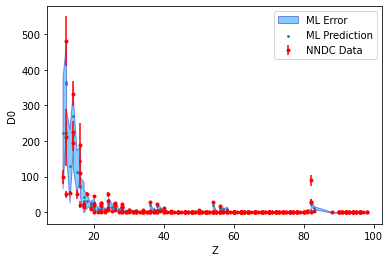

In [152]:
plt.errorbar(signal['Z'],signal['D0'],yerr=signal['dD'],fmt='o',markersize=3, color='red',label='NNDC Data')
plt.fill_between(signal['Z'], y_pred - np.sqrt(rf_err), y_pred + np.sqrt(rf_err), alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF',label='ML Error')
plt.scatter(arr_x[:,0],y_pred,s=3,label='ML Prediction')
# plt.xlim(22,42)
# plt.ylim(0,80)
plt.legend()
plt.xlabel("Z")
plt.ylabel("D0")
plt.show()

In [157]:
y_pred = rf.predict(test_data)
rf_err = abs(fci.random_forest_error(rf,arr_x,test_data,calibrate=False))

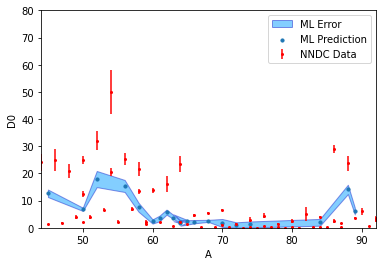

In [168]:
plt.errorbar(signal['A'],signal['D0'],yerr=signal['dD'],fmt='o',markersize=2, color='red',label='NNDC Data')
plt.fill_between(test_data[:,1], y_pred - np.sqrt(rf_err), y_pred + np.sqrt(rf_err), alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF',label='ML Error')
plt.scatter(test_data[:,1],y_pred,s=10,label='ML Prediction')
plt.xlim(44,92)
plt.ylim(0,80)
plt.legend()
plt.xlabel("A")
plt.ylabel("D0")
plt.show()